# Proyek Dicoding: Sentimen Analisis Pada Game Minecraft


- Nama: Dzulfikri Adjmal
- Email: dzulfikriadjmal@gmail.com
- ID Dicoding: dzulfikriadjmal

In [67]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    LSTM,
    Dense,
    Dropout,
    Bidirectional,
    Conv1D,
    MaxPooling1D,
    SimpleRNN,
)
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import re
import csv
from io import StringIO

import requests
import string

import tqdm


pd.options.mode.chained_assignment = None

In [3]:
df_reviews = pd.read_csv(f"./dataset/ulasan_minecraft_50000.csv")
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  49999 non-null  object
dtypes: object(1)
memory usage: 390.8+ KB


In [4]:
df_reviews.head()

,Review
0,"Bagus sih,cuma tolong fix di bagian freeze. Ma..."
1,"Sedikit kecewa di update 1.21.2, bukannya tamb..."
2,"Sudah sangat bagus, saya sudah bermain sangat ..."
3,Gamenya bagus mantap dari dulu sampe sekarang....
4,Terima kasih mojang studios atas diskon besar ...


In [5]:
df_reviews.duplicated().sum()

7922

In [6]:
df_reviews.isna().sum()

Review    1
dtype: int64

In [7]:
df_reviews.drop_duplicates(inplace=True)

In [8]:
df_reviews.dropna(inplace=True)

## Preprocessing Data

### Pembersihan data

In [9]:
def cleaning_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\S+", "", text)
    text = re.sub(r"#\S+", "", text)
    text = re.sub(r"[^A-Za-z]+", " ", text)

    text = text.replace("\n", " ")
    text = text.translate(str.maketrans("", "", string.punctuation))

    text = text.strip()

    vowels = re.findall(r"[aiueoAIUEO]{3,}", text)
    non_vowels = re.findall(r"[^aiueoAIUEO\s]{3,}", text)

    if vowels or non_vowels:
        for vowel in vowels:
            text = text.replace(vowel, vowel[0])
        for non_vowel in non_vowels:
            text = text.replace(non_vowel, non_vowel[0])

    return text


df_reviews["Review_remove_special_char"] = df_reviews["Review"].apply(cleaning_text)
df_reviews

,Review,Review_remove_special_char
0,"Bagus sih,cuma tolong fix di bagian freeze. Ma...",Bagus sih cuma tolong fix di bagian freeze Mak...
1,"Sedikit kecewa di update 1.21.2, bukannya tamb...",Sedikit kecewa di update bukana tambah optimal...
2,"Sudah sangat bagus, saya sudah bermain sangat ...",Sudah sangat bagus saya sudah bermain sangat l...
3,Gamenya bagus mantap dari dulu sampe sekarang....,Gamenya bagus mantap dari dulu sampe sekarang ...
4,Terima kasih mojang studios atas diskon besar ...,Terima kasih mojang studios atas diskon besar ...
...,...,...
49993,Game mencrep I 😭😭😭😭,Game menep I
49994,this game Minecraft is the best 👍👍,this game Minecraft is the best
49995,game kancut,game kancut
49996,Creative and fun,Creative and fun


### Case Folding

In [10]:
df_reviews["Review_lowercased"] = df_reviews["Review_remove_special_char"].str.lower()
df_reviews

,Review,Review_remove_special_char,Review_lowercased
0,"Bagus sih,cuma tolong fix di bagian freeze. Ma...",Bagus sih cuma tolong fix di bagian freeze Mak...,bagus sih cuma tolong fix di bagian freeze mak...
1,"Sedikit kecewa di update 1.21.2, bukannya tamb...",Sedikit kecewa di update bukana tambah optimal...,sedikit kecewa di update bukana tambah optimal...
2,"Sudah sangat bagus, saya sudah bermain sangat ...",Sudah sangat bagus saya sudah bermain sangat l...,sudah sangat bagus saya sudah bermain sangat l...
3,Gamenya bagus mantap dari dulu sampe sekarang....,Gamenya bagus mantap dari dulu sampe sekarang ...,gamenya bagus mantap dari dulu sampe sekarang ...
4,Terima kasih mojang studios atas diskon besar ...,Terima kasih mojang studios atas diskon besar ...,terima kasih mojang studios atas diskon besar ...
...,...,...,...
49993,Game mencrep I 😭😭😭😭,Game menep I,game menep i
49994,this game Minecraft is the best 👍👍,this game Minecraft is the best,this game minecraft is the best
49995,game kancut,game kancut,game kancut
49996,Creative and fun,Creative and fun,creative and fun


In [11]:
df_reviews["Review_remove_special_char"] = df_reviews[
    "Review_remove_special_char"
].replace(r"^\s*$", np.nan, regex=True)
df_reviews.dropna(subset=["Review_remove_special_char"], inplace=True)
df_reviews

,Review,Review_remove_special_char,Review_lowercased
0,"Bagus sih,cuma tolong fix di bagian freeze. Ma...",Bagus sih cuma tolong fix di bagian freeze Mak...,bagus sih cuma tolong fix di bagian freeze mak...
1,"Sedikit kecewa di update 1.21.2, bukannya tamb...",Sedikit kecewa di update bukana tambah optimal...,sedikit kecewa di update bukana tambah optimal...
2,"Sudah sangat bagus, saya sudah bermain sangat ...",Sudah sangat bagus saya sudah bermain sangat l...,sudah sangat bagus saya sudah bermain sangat l...
3,Gamenya bagus mantap dari dulu sampe sekarang....,Gamenya bagus mantap dari dulu sampe sekarang ...,gamenya bagus mantap dari dulu sampe sekarang ...
4,Terima kasih mojang studios atas diskon besar ...,Terima kasih mojang studios atas diskon besar ...,terima kasih mojang studios atas diskon besar ...
...,...,...,...
49993,Game mencrep I 😭😭😭😭,Game menep I,game menep i
49994,this game Minecraft is the best 👍👍,this game Minecraft is the best,this game minecraft is the best
49995,game kancut,game kancut,game kancut
49996,Creative and fun,Creative and fun,creative and fun


### Tokenisasi

In [12]:
def str_to_token(text):
    return word_tokenize(text)

df_reviews["Review_tokenizing"] = df_reviews["Review_lowercased"].apply(str_to_token)
df_reviews

,Review,Review_remove_special_char,Review_lowercased,Review_tokenizing
0,"Bagus sih,cuma tolong fix di bagian freeze. Ma...",Bagus sih cuma tolong fix di bagian freeze Mak...,bagus sih cuma tolong fix di bagian freeze mak...,"[bagus, sih, cuma, tolong, fix, di, bagian, fr..."
1,"Sedikit kecewa di update 1.21.2, bukannya tamb...",Sedikit kecewa di update bukana tambah optimal...,sedikit kecewa di update bukana tambah optimal...,"[sedikit, kecewa, di, update, bukana, tambah, ..."
2,"Sudah sangat bagus, saya sudah bermain sangat ...",Sudah sangat bagus saya sudah bermain sangat l...,sudah sangat bagus saya sudah bermain sangat l...,"[sudah, sangat, bagus, saya, sudah, bermain, s..."
3,Gamenya bagus mantap dari dulu sampe sekarang....,Gamenya bagus mantap dari dulu sampe sekarang ...,gamenya bagus mantap dari dulu sampe sekarang ...,"[gamenya, bagus, mantap, dari, dulu, sampe, se..."
4,Terima kasih mojang studios atas diskon besar ...,Terima kasih mojang studios atas diskon besar ...,terima kasih mojang studios atas diskon besar ...,"[terima, kasih, mojang, studios, atas, diskon,..."
...,...,...,...,...
49993,Game mencrep I 😭😭😭😭,Game menep I,game menep i,"[game, menep, i]"
49994,this game Minecraft is the best 👍👍,this game Minecraft is the best,this game minecraft is the best,"[this, game, minecraft, is, the, best]"
49995,game kancut,game kancut,game kancut,"[game, kancut]"
49996,Creative and fun,Creative and fun,creative and fun,"[creative, and, fun]"


### Normalisasi dari kata-kata yang tidak baku

In [13]:
def retrieve_from_web(link):
    response = requests.get(link)

    if response.status_code == 200:
        return response.text

    return None


CORPUS_TIDAK_BAKU = {}

kbba = retrieve_from_web(
    "https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/kbba.txt"
)
kbba = StringIO(kbba)
kbba = csv.reader(kbba, delimiter="\t")

for row in kbba:
    CORPUS_TIDAK_BAKU[row[0]] = row[1]

CORPUS_SLANG = {}
slang_combine = retrieve_from_web(
    "https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_slang_words.txt"
)

slang_combine = StringIO(slang_combine)
slang_combine = slang_combine.getvalue().replace("{", "").replace("}", "").split(",")

for slang in slang_combine:
    slang = slang.split(":")
    key = re.sub(r"[^A-Za-z@] ", "", slang[0])
    if len(slang) == 2:
        CORPUS_SLANG[key] = re.sub(r"[^A-Za-z@ ]", "", slang[1])
    else:
        CORPUS_SLANG[slang[0]] = ""

CORPUS_TIDAK_BAKU.update(CORPUS_SLANG)
CORPUS_TIDAK_BAKU

SINGKATAN = {
    "gi": "genshin impact",
    "gg": "good game",
    "nt": "nice try",
    "gl": "good luck",
    "hf": "have fun",
    "wp": "well played",
    "hsr": "honkai star rail",
    "sub": "subtitle",
    "subs": "subtitles",
    "fps": "frame per second",
    "jlk": "jelek",
    "g": "tidak",
    "tpi": "tapi",
    "p": "halo",
    "hp": "handphone",
    "lg": "lagi",
    "ni": "ini",
    "in": "ini",
    "bagu": "bagus",
    "dowoad": "download",
    "moga": "semoga",
    "akhira": "akhirnya",
    "inall": "install",
    "ajg": "anjing",
    "apdet": "update",
    "apdetan": "update",
    "apk": "aplikasi",
    "yaa": "ya",
    "baguss": "bagus",
    "benara": "benar",
    "bgs": "bagus",
    "berikuta": "berikut",
    "bgus": "bagus",
    "biome": "bioma",
    "boong": "bohong",
    "buga": "bug",
    "dimainin": "dimainkan",
    "diskona": "diskon",
    "donload": "download",
    "donlod": "download",
    "donoad": "downlaod",
    "dowload": "download",
    "eror": "error",
    "freze": "freeze",
    "gajelas": "tidak jelas",
    "gamenya": "game",
    "games": "game",
    "grafika": "grafik",
    "gratisa": "gratis",
    "gratisin": "gratis",
    "gunakan": "guna",
    "kasi": "kasih",
}

CORPUS_TIDAK_BAKU.update(SINGKATAN)

In [14]:
df_reviews["Review_normalization"] = df_reviews["Review_tokenizing"].apply(
    lambda x: [
        CORPUS_TIDAK_BAKU[word] if word in CORPUS_TIDAK_BAKU else word for word in x
    ]
)
df_reviews

,Review,Review_remove_special_char,Review_lowercased,Review_tokenizing,Review_normalization
0,"Bagus sih,cuma tolong fix di bagian freeze. Ma...",Bagus sih cuma tolong fix di bagian freeze Mak...,bagus sih cuma tolong fix di bagian freeze mak...,"[bagus, sih, cuma, tolong, fix, di, bagian, fr...","[bagus, sih, cuma, tolong, fix, di, bagian, fr..."
1,"Sedikit kecewa di update 1.21.2, bukannya tamb...",Sedikit kecewa di update bukana tambah optimal...,sedikit kecewa di update bukana tambah optimal...,"[sedikit, kecewa, di, update, bukana, tambah, ...","[sedikit, kecewa, di, update, bukana, tambah, ..."
2,"Sudah sangat bagus, saya sudah bermain sangat ...",Sudah sangat bagus saya sudah bermain sangat l...,sudah sangat bagus saya sudah bermain sangat l...,"[sudah, sangat, bagus, saya, sudah, bermain, s...","[sudah, sangat, bagus, saya, sudah, bermain, s..."
3,Gamenya bagus mantap dari dulu sampe sekarang....,Gamenya bagus mantap dari dulu sampe sekarang ...,gamenya bagus mantap dari dulu sampe sekarang ...,"[gamenya, bagus, mantap, dari, dulu, sampe, se...","[game, bagus, mantap, dari, dulu, sampai, seka..."
4,Terima kasih mojang studios atas diskon besar ...,Terima kasih mojang studios atas diskon besar ...,terima kasih mojang studios atas diskon besar ...,"[terima, kasih, mojang, studios, atas, diskon,...","[terima, kasih, mojang, studios, atas, diskon,..."
...,...,...,...,...,...
49993,Game mencrep I 😭😭😭😭,Game menep I,game menep i,"[game, menep, i]","[game, menep, i]"
49994,this game Minecraft is the best 👍👍,this game Minecraft is the best,this game minecraft is the best,"[this, game, minecraft, is, the, best]","[this, game, minecraft, is, the, best]"
49995,game kancut,game kancut,game kancut,"[game, kancut]","[game, kancut]"
49996,Creative and fun,Creative and fun,creative and fun,"[creative, and, fun]","[creative, and, fun]"


### Remove Stopwords

In [15]:
def remove_stopwords(text):
    stop_words = set(stopwords.words("indonesian"))
    return [word for word in text if word not in stop_words]


df_reviews["Review_stopword"] = df_reviews["Review_normalization"].apply(
    remove_stopwords
)
df_reviews

,Review,Review_remove_special_char,Review_lowercased,Review_tokenizing,Review_normalization,Review_stopword
0,"Bagus sih,cuma tolong fix di bagian freeze. Ma...",Bagus sih cuma tolong fix di bagian freeze Mak...,bagus sih cuma tolong fix di bagian freeze mak...,"[bagus, sih, cuma, tolong, fix, di, bagian, fr...","[bagus, sih, cuma, tolong, fix, di, bagian, fr...","[bagus, sih, tolong, fix, freeze, maksud, laya..."
1,"Sedikit kecewa di update 1.21.2, bukannya tamb...",Sedikit kecewa di update bukana tambah optimal...,sedikit kecewa di update bukana tambah optimal...,"[sedikit, kecewa, di, update, bukana, tambah, ...","[sedikit, kecewa, di, update, bukana, tambah, ...","[kecewa, update, bukana, optimal, jusu, berat,..."
2,"Sudah sangat bagus, saya sudah bermain sangat ...",Sudah sangat bagus saya sudah bermain sangat l...,sudah sangat bagus saya sudah bermain sangat l...,"[sudah, sangat, bagus, saya, sudah, bermain, s...","[sudah, sangat, bagus, saya, sudah, bermain, s...","[bagus, bermain, frezze, game, pengaturan, f, ..."
3,Gamenya bagus mantap dari dulu sampe sekarang....,Gamenya bagus mantap dari dulu sampe sekarang ...,gamenya bagus mantap dari dulu sampe sekarang ...,"[gamenya, bagus, mantap, dari, dulu, sampe, se...","[game, bagus, mantap, dari, dulu, sampai, seka...","[game, bagus, mantap, tolong, optimalkan, game..."
4,Terima kasih mojang studios atas diskon besar ...,Terima kasih mojang studios atas diskon besar ...,terima kasih mojang studios atas diskon besar ...,"[terima, kasih, mojang, studios, atas, diskon,...","[terima, kasih, mojang, studios, atas, diskon,...","[terima, kasih, mojang, studios, diskon, besar..."
...,...,...,...,...,...,...
49993,Game mencrep I 😭😭😭😭,Game menep I,game menep i,"[game, menep, i]","[game, menep, i]","[game, menep, i]"
49994,this game Minecraft is the best 👍👍,this game Minecraft is the best,this game minecraft is the best,"[this, game, minecraft, is, the, best]","[this, game, minecraft, is, the, best]","[this, game, minecraft, is, the, best]"
49995,game kancut,game kancut,game kancut,"[game, kancut]","[game, kancut]","[game, kancut]"
49996,Creative and fun,Creative and fun,creative and fun,"[creative, and, fun]","[creative, and, fun]","[creative, and, fun]"


In [16]:
# split item pada list yang lebih dari satu kata
def split_word(text):
    for t in text:
        if " " in t:
            index = text.index(t)
            text.pop(index)
            for w in t.split():
                text.insert(index, w)
                index += 1
    return text


df_reviews["Review_stopword"] = df_reviews["Review_stopword"].apply(split_word)
df_reviews

,Review,Review_remove_special_char,Review_lowercased,Review_tokenizing,Review_normalization,Review_stopword
0,"Bagus sih,cuma tolong fix di bagian freeze. Ma...",Bagus sih cuma tolong fix di bagian freeze Mak...,bagus sih cuma tolong fix di bagian freeze mak...,"[bagus, sih, cuma, tolong, fix, di, bagian, fr...","[bagus, sih, cuma, tolong, fix, di, bagian, fr...","[bagus, sih, tolong, fix, freeze, maksud, laya..."
1,"Sedikit kecewa di update 1.21.2, bukannya tamb...",Sedikit kecewa di update bukana tambah optimal...,sedikit kecewa di update bukana tambah optimal...,"[sedikit, kecewa, di, update, bukana, tambah, ...","[sedikit, kecewa, di, update, bukana, tambah, ...","[kecewa, update, bukana, optimal, jusu, berat,..."
2,"Sudah sangat bagus, saya sudah bermain sangat ...",Sudah sangat bagus saya sudah bermain sangat l...,sudah sangat bagus saya sudah bermain sangat l...,"[sudah, sangat, bagus, saya, sudah, bermain, s...","[sudah, sangat, bagus, saya, sudah, bermain, s...","[bagus, bermain, frezze, game, pengaturan, f, ..."
3,Gamenya bagus mantap dari dulu sampe sekarang....,Gamenya bagus mantap dari dulu sampe sekarang ...,gamenya bagus mantap dari dulu sampe sekarang ...,"[gamenya, bagus, mantap, dari, dulu, sampe, se...","[game, bagus, mantap, dari, dulu, sampai, seka...","[game, bagus, mantap, tolong, optimalkan, game..."
4,Terima kasih mojang studios atas diskon besar ...,Terima kasih mojang studios atas diskon besar ...,terima kasih mojang studios atas diskon besar ...,"[terima, kasih, mojang, studios, atas, diskon,...","[terima, kasih, mojang, studios, atas, diskon,...","[terima, kasih, mojang, studios, diskon, besar..."
...,...,...,...,...,...,...
49993,Game mencrep I 😭😭😭😭,Game menep I,game menep i,"[game, menep, i]","[game, menep, i]","[game, menep, i]"
49994,this game Minecraft is the best 👍👍,this game Minecraft is the best,this game minecraft is the best,"[this, game, minecraft, is, the, best]","[this, game, minecraft, is, the, best]","[this, game, minecraft, is, the, best]"
49995,game kancut,game kancut,game kancut,"[game, kancut]","[game, kancut]","[game, kancut]"
49996,Creative and fun,Creative and fun,creative and fun,"[creative, and, fun]","[creative, and, fun]","[creative, and, fun]"


### Stemming

In [17]:
stemmer = StemmerFactory().create_stemmer()


def stemming_text(text):
    return [stemmer.stem(word) for word in text]


df_reviews["Review_stemmed"] = None

for index, row in tqdm.tqdm(
    df_reviews.iterrows(),
    desc="Stemming",
    total=df_reviews.shape[0],
    unit="row",
):
    df_reviews.at[index, "Review_stemmed"] = stemming_text(row["Review_stopword"])

df_reviews

Stemming: 100%|██████████| 41637/41637 [27:42<00:00, 25.04row/s]  


,Review,Review_remove_special_char,Review_lowercased,Review_tokenizing,Review_normalization,Review_stopword,Review_stemmed
0,"Bagus sih,cuma tolong fix di bagian freeze. Ma...",Bagus sih cuma tolong fix di bagian freeze Mak...,bagus sih cuma tolong fix di bagian freeze mak...,"[bagus, sih, cuma, tolong, fix, di, bagian, fr...","[bagus, sih, cuma, tolong, fix, di, bagian, fr...","[bagus, sih, tolong, fix, freeze, maksud, laya...","[bagus, sih, tolong, fix, freeze, maksud, laya..."
1,"Sedikit kecewa di update 1.21.2, bukannya tamb...",Sedikit kecewa di update bukana tambah optimal...,sedikit kecewa di update bukana tambah optimal...,"[sedikit, kecewa, di, update, bukana, tambah, ...","[sedikit, kecewa, di, update, bukana, tambah, ...","[kecewa, update, bukana, optimal, jusu, berat,...","[kecewa, update, bukana, optimal, jusu, berat,..."
2,"Sudah sangat bagus, saya sudah bermain sangat ...",Sudah sangat bagus saya sudah bermain sangat l...,sudah sangat bagus saya sudah bermain sangat l...,"[sudah, sangat, bagus, saya, sudah, bermain, s...","[sudah, sangat, bagus, saya, sudah, bermain, s...","[bagus, bermain, frezze, game, pengaturan, f, ...","[bagus, main, frezze, game, atur, f, batas, at..."
3,Gamenya bagus mantap dari dulu sampe sekarang....,Gamenya bagus mantap dari dulu sampe sekarang ...,gamenya bagus mantap dari dulu sampe sekarang ...,"[gamenya, bagus, mantap, dari, dulu, sampe, se...","[game, bagus, mantap, dari, dulu, sampai, seka...","[game, bagus, mantap, tolong, optimalkan, game...","[game, bagus, mantap, tolong, optimal, game, l..."
4,Terima kasih mojang studios atas diskon besar ...,Terima kasih mojang studios atas diskon besar ...,terima kasih mojang studios atas diskon besar ...,"[terima, kasih, mojang, studios, atas, diskon,...","[terima, kasih, mojang, studios, atas, diskon,...","[terima, kasih, mojang, studios, diskon, besar...","[terima, kasih, mojang, studios, diskon, besar..."
...,...,...,...,...,...,...,...
49993,Game mencrep I 😭😭😭😭,Game menep I,game menep i,"[game, menep, i]","[game, menep, i]","[game, menep, i]","[game, menep, i]"
49994,this game Minecraft is the best 👍👍,this game Minecraft is the best,this game minecraft is the best,"[this, game, minecraft, is, the, best]","[this, game, minecraft, is, the, best]","[this, game, minecraft, is, the, best]","[this, game, minecraft, is, the, best]"
49995,game kancut,game kancut,game kancut,"[game, kancut]","[game, kancut]","[game, kancut]","[game, kancut]"
49996,Creative and fun,Creative and fun,creative and fun,"[creative, and, fun]","[creative, and, fun]","[creative, and, fun]","[creative, and, fun]"


### Ubah ke kalimat utuh

In [18]:
def to_sentence(text):
    return " ".join(word for word in text)

df_reviews["Review Final"] = df_reviews["Review_stemmed"].apply(to_sentence)
df_reviews

,Review,Review_remove_special_char,Review_lowercased,Review_tokenizing,Review_normalization,Review_stopword,Review_stemmed,Review Final
0,"Bagus sih,cuma tolong fix di bagian freeze. Ma...",Bagus sih cuma tolong fix di bagian freeze Mak...,bagus sih cuma tolong fix di bagian freeze mak...,"[bagus, sih, cuma, tolong, fix, di, bagian, fr...","[bagus, sih, cuma, tolong, fix, di, bagian, fr...","[bagus, sih, tolong, fix, freeze, maksud, laya...","[bagus, sih, tolong, fix, freeze, maksud, laya...",bagus sih tolong fix freeze maksud layar freez...
1,"Sedikit kecewa di update 1.21.2, bukannya tamb...",Sedikit kecewa di update bukana tambah optimal...,sedikit kecewa di update bukana tambah optimal...,"[sedikit, kecewa, di, update, bukana, tambah, ...","[sedikit, kecewa, di, update, bukana, tambah, ...","[kecewa, update, bukana, optimal, jusu, berat,...","[kecewa, update, bukana, optimal, jusu, berat,...",kecewa update bukana optimal jusu berat layar ...
2,"Sudah sangat bagus, saya sudah bermain sangat ...",Sudah sangat bagus saya sudah bermain sangat l...,sudah sangat bagus saya sudah bermain sangat l...,"[sudah, sangat, bagus, saya, sudah, bermain, s...","[sudah, sangat, bagus, saya, sudah, bermain, s...","[bagus, bermain, frezze, game, pengaturan, f, ...","[bagus, main, frezze, game, atur, f, batas, at...",bagus main frezze game atur f batas atur video...
3,Gamenya bagus mantap dari dulu sampe sekarang....,Gamenya bagus mantap dari dulu sampe sekarang ...,gamenya bagus mantap dari dulu sampe sekarang ...,"[gamenya, bagus, mantap, dari, dulu, sampe, se...","[game, bagus, mantap, dari, dulu, sampai, seka...","[game, bagus, mantap, tolong, optimalkan, game...","[game, bagus, mantap, tolong, optimal, game, l...",game bagus mantap tolong optimal game lag fram...
4,Terima kasih mojang studios atas diskon besar ...,Terima kasih mojang studios atas diskon besar ...,terima kasih mojang studios atas diskon besar ...,"[terima, kasih, mojang, studios, atas, diskon,...","[terima, kasih, mojang, studios, atas, diskon,...","[terima, kasih, mojang, studios, diskon, besar...","[terima, kasih, mojang, studios, diskon, besar...",terima kasih mojang studios diskon besar minec...
...,...,...,...,...,...,...,...,...
49993,Game mencrep I 😭😭😭😭,Game menep I,game menep i,"[game, menep, i]","[game, menep, i]","[game, menep, i]","[game, menep, i]",game menep i
49994,this game Minecraft is the best 👍👍,this game Minecraft is the best,this game minecraft is the best,"[this, game, minecraft, is, the, best]","[this, game, minecraft, is, the, best]","[this, game, minecraft, is, the, best]","[this, game, minecraft, is, the, best]",this game minecraft is the best
49995,game kancut,game kancut,game kancut,"[game, kancut]","[game, kancut]","[game, kancut]","[game, kancut]",game kancut
49996,Creative and fun,Creative and fun,creative and fun,"[creative, and, fun]","[creative, and, fun]","[creative, and, fun]","[creative, and, fun]",creative and fun


In [19]:
df_reviews[df_reviews["Review Final"] == ""]

,Review,Review_remove_special_char,Review_lowercased,Review_tokenizing,Review_normalization,Review_stopword,Review_stemmed,Review Final
6996,Tidak bisa digunakan,Tidak bisa digunakan,tidak bisa digunakan,"[tidak, bisa, digunakan]","[tidak, bisa, digunakan]",[],[],
8390,Sangat luar biasa,Sangat luar biasa,sangat luar biasa,"[sangat, luar, biasa]","[sangat, luar, biasa]",[],[],
10253,Keluar keluar terusssssss,Keluar keluar terus,keluar keluar terus,"[keluar, keluar, terus]","[keluar, keluar, terus]",[],[],
13358,Sangat luar biasa?,Sangat luar biasa,sangat luar biasa,"[sangat, luar, biasa]","[sangat, luar, biasa]",[],[],
14033,Sejauh ini baik🔥🔥🔥,Sejauh ini baik,sejauh ini baik,"[sejauh, ini, baik]","[sejauh, ini, baik]",[],[],
...,...,...,...,...,...,...,...,...
48442,Akhirnya....,Akhira,akhira,[akhira],[akhirnya],[],[],
48807,saya,saya,saya,[saya],[saya],[],[],
48845,Ini baru,Ini baru,ini baru,"[ini, baru]","[ini, baru]",[],[],
49154,Tapi,Tapi,tapi,[tapi],[tapi],[],[],


In [20]:
df_reviews["Review Final"].replace("", np.nan, inplace=True)
df_reviews.dropna(subset=["Review Final"], inplace=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_8720\505935532.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_reviews["Review Final"].replace("", np.nan, inplace=True)


In [21]:
indonesia_lexicon = {}

lexicon_response_pos = retrieve_from_web(
    link="https://raw.githubusercontent.com/fajri91/InSet/master/positive.tsv"
)

lexicon_response_neg = retrieve_from_web(
    link="https://raw.githubusercontent.com/fajri91/InSet/master/negative.tsv"
)

reader_pos = csv.reader(StringIO(lexicon_response_pos), delimiter="\t")

for row in reader_pos:
    # pass header
    if row[0] == "word" and row[1] == "weight":
        continue
    indonesia_lexicon[row[0]] = int(row[1])

reader_neg = csv.reader(StringIO(lexicon_response_neg), delimiter="\t")

for row in reader_neg:
    # pass header
    if row[0] == "word" and row[1] == "weight":
        continue
    indonesia_lexicon[row[0]] = int(row[1])


In [22]:
analyzer_english = SentimentIntensityAnalyzer()


def sentiment_by_lexicon(text):
    score = 0

    for word in text:
        if word in indonesia_lexicon:
            score += indonesia_lexicon[word]
        else:
            vader_score = analyzer_english.polarity_scores(word)["compound"]
            score += vader_score

    polarity = ""

    if score > 0:
        polarity = "positive"
    elif score < 0:
        polarity = "negative"
    else:
        polarity = "neutral"

    return score, polarity


In [23]:
labels_sentiments = df_reviews["Review_stemmed"].apply(sentiment_by_lexicon)
labels_sentiments = list(zip(*labels_sentiments))

df_reviews["score"] = labels_sentiments[0]
df_reviews["sentiment"] = labels_sentiments[1]
df_reviews["sentiment"].value_counts()


sentiment
negative    24987
positive    10832
neutral      5696
Name: count, dtype: int64

### Mengambil sebagian data untuk training dan testing

In [24]:
df_positive = df_reviews[df_reviews["sentiment"] == "positive"].sample(
    5000, random_state=42
)
df_negative = df_reviews[df_reviews["sentiment"] == "negative"].sample(
    5000, random_state=42
)
df_neutral = df_reviews[df_reviews["sentiment"] == "neutral"].sample(
    5000, random_state=42
)

df_selected = pd.concat([df_positive, df_negative, df_neutral], ignore_index=True)
df_selected["sentiment"].value_counts()


sentiment
positive    5000
negative    5000
neutral     5000
Name: count, dtype: int64

In [25]:
df_selected.to_csv(f"./dataset/ulasan_minecraft_selected.csv", index=False)

In [26]:
df_minecraft = pd.read_csv('./dataset/ulasan_minecraft_selected.csv')
df_minecraft.head()

,Review,Review_remove_special_char,Review_lowercased,Review_tokenizing,Review_normalization,Review_stopword,Review_stemmed,Review Final,score,sentiment
0,Bugnya udah hilang. Kini bisa main Skywars den...,Buga udah hilang Kini bisa main Sars dengan ny...,buga udah hilang kini bisa main sars dengan ny...,"['buga', 'udah', 'hilang', 'kini', 'bisa', 'ma...","['bug', 'sudah', 'hilang', 'kini', 'bisa', 'ma...","['bug', 'hilang', 'main', 'sars', 'nyaman', 't...","['bug', 'hilang', 'main', 'sars', 'nyaman', 't...",bug hilang main sars nyaman terima kasih mojang,1.0000,positive
1,Selamat malam minecraft kok minecraft jadi gra...,Selamat malam minecraft kok minecraft jadi gra...,selamat malam minecraft kok minecraft jadi gra...,"['selamat', 'malam', 'minecraft', 'kok', 'mine...","['selamat', 'malam', 'minecraft', 'kok', 'mine...","['selamat', 'malam', 'minecraft', 'minecraft',...","['selamat', 'malam', 'minecraft', 'minecraft',...",selamat malam minecraft minecraft gratis iya k...,9.0000,positive
2,"Gameplay nya bagus,mantap dah",Gameplay nya bagus mantap dah,gameplay nya bagus mantap dah,"['gameplay', 'nya', 'bagus', 'mantap', 'dah']","['gameplay', 'nya', 'bagus', 'mantap', 'deh']","['gameplay', 'nya', 'bagus', 'mantap', 'deh']","['gameplay', 'nya', 'bagus', 'mantap', 'deh']",gameplay nya bagus mantap deh,1.0000,positive
3,Game ini sangat bermanfaat sekali aku suka ban...,Game ini sangat bermanfaat sekali aku suka ban...,game ini sangat bermanfaat sekali aku suka ban...,"['game', 'ini', 'sangat', 'bermanfaat', 'sekal...","['game', 'ini', 'sangat', 'bermanfaat', 'sekal...","['game', 'bermanfaat', 'suka', 'banget', 'semo...","['game', 'manfaat', 'suka', 'banget', 'moga', ...",game manfaat suka banget moga mojang update ba...,6.3182,positive
4,Game ini bagus sekali ibu. terimakasih ibu tel...,Game ini bagus sekali ibu terimakasih ibu tela...,game ini bagus sekali ibu terimakasih ibu tela...,"['game', 'ini', 'bagus', 'sekali', 'ibu', 'ter...","['game', 'ini', 'bagus', 'sekali', 'ibu', 'ter...","['game', 'bagus', 'terimakasih', 'merekomendas...","['game', 'bagus', 'terimakasih', 'rekomendasi'...",game bagus terimakasih rekomendasi game ku suk...,13.0000,positive


In [27]:
df_minecraft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Review                      15000 non-null  object 
 1   Review_remove_special_char  15000 non-null  object 
 2   Review_lowercased           15000 non-null  object 
 3   Review_tokenizing           15000 non-null  object 
 4   Review_normalization        15000 non-null  object 
 5   Review_stopword             15000 non-null  object 
 6   Review_stemmed              15000 non-null  object 
 7   Review Final                14988 non-null  object 
 8   score                       15000 non-null  float64
 9   sentiment                   15000 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.1+ MB


In [28]:
df_minecraft_review = df_minecraft[['Review Final', 'sentiment']].copy()
df_minecraft_review = df_minecraft_review.sample(frac=1).reset_index(drop=True) # shuffle data

In [29]:
df_minecraft_review.dropna(inplace=True)

In [30]:
review_positif = df_minecraft_review[df_minecraft_review['sentiment'] == 'positive']
review_negatif = df_minecraft_review[df_minecraft_review['sentiment'] == 'negative']
review_netral = df_minecraft_review[df_minecraft_review['sentiment'] == 'neutral']

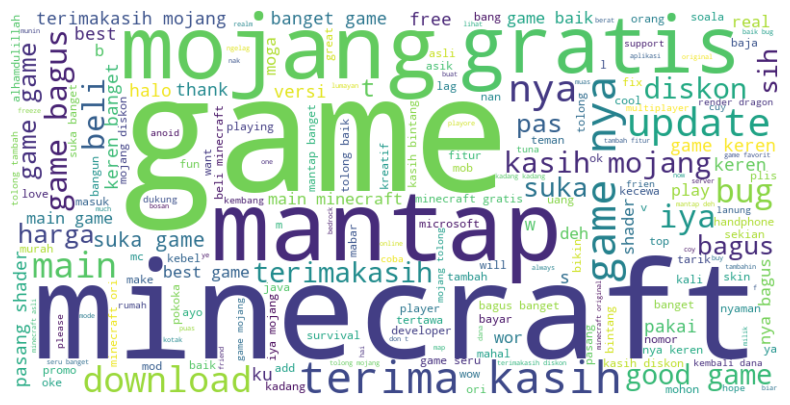

In [31]:
wordcloud_positif = WordCloud(width = 800, height = 400, background_color='white')
wordcloud_positif.generate(' '.join(str(word) for word in review_positif['Review Final']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.axis('off')
plt.show()

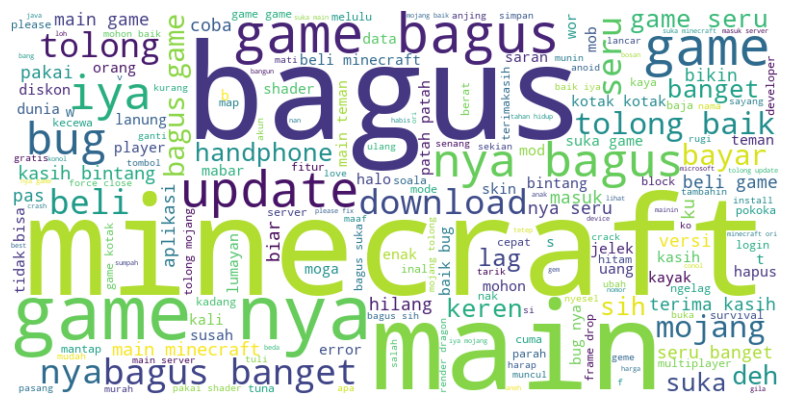

In [32]:
wordcloud_negatif = WordCloud(width=800, height=400, background_color="white")
wordcloud_negatif.generate(" ".join(str(word) for word in review_negatif['Review Final']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negatif, interpolation="bilinear")
plt.axis("off")
plt.show()


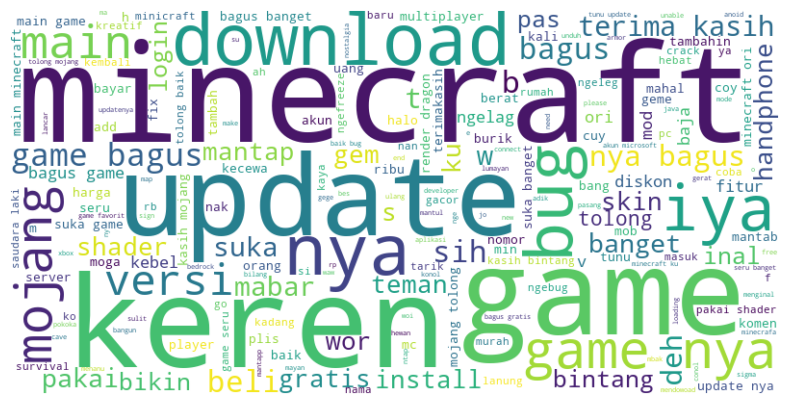

In [33]:
wordcloud_netral = WordCloud(width=800, height=400, background_color="white")
wordcloud_netral.generate(" ".join(str(word) for word in review_netral["Review Final"]))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_netral, interpolation="bilinear")
plt.axis("off")
plt.show()


In [34]:
X = df_minecraft_review["Review Final"]
y = df_minecraft_review["sentiment"]

y = y.map({"positive": 1, "negative": 0, "neutral": 2})

## SVM dengan TF-IDF

In [35]:
tf_idf = TfidfVectorizer(max_features=1000, min_df=10, max_df=0.5)
X_tf_idf = tf_idf.fit_transform(X)
X_tf_idf = X_tf_idf.toarray()

feature_df = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())

feature_df

,abang,about,account,achievement,add,addon,addons,adik,adventure,after,...,yak,ye,years,yes,yey,you,your,youtube,youtuber,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y, test_size=0.2, random_state=42)

In [37]:
model_svc = SVC()
model_svc.fit(X_train, y_train)

SVC()

In [38]:
test_pred = model_svc.predict(X_test)
train_pred = model_svc.predict(X_train)

print('Akurasi Train:', accuracy_score(y_train, train_pred))
print('Akurasi Test:', accuracy_score(y_test, test_pred))

Akurasi Train: 0.9604670558798999
Akurasi Test: 0.8669112741827886


In [39]:
print('Confusion Matrix :\n', confusion_matrix(y_test, test_pred))

Confusion Matrix :
 [[840  48  79]
 [ 46 905  88]
 [ 75  63 854]]


In [40]:
print('Classification Report :', classification_report(y_test, test_pred))

Classification Report :               precision    recall  f1-score   support

           0       0.87      0.87      0.87       967
           1       0.89      0.87      0.88      1039
           2       0.84      0.86      0.85       992

    accuracy                           0.87      2998
   macro avg       0.87      0.87      0.87      2998
weighted avg       0.87      0.87      0.87      2998



### Model LSTM

In [41]:
VOCAB = 1000
EMBEDDING = 48
MAX_LENGTH = 48

In [42]:
text_train, text_test, label_train, label_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
tokenizer = Tokenizer(num_words=VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(text_train)
X_pad = pad_sequences(X_seq, maxlen=MAX_LENGTH, padding='post')

y_seq = tokenizer.texts_to_sequences(text_test)
y_pad = pad_sequences(y_seq, maxlen=MAX_LENGTH, padding='post')

In [44]:
y_pad.shape

(4497, 48)

In [45]:
model_lstm = Sequential(
    [
        Embedding(VOCAB, EMBEDDING, input_length=(MAX_LENGTH, )),
        Bidirectional(LSTM(128, return_sequences=True)),
        Conv1D(64, 5, activation='relu'),
        MaxPooling1D(2),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ]
)

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\Asus\Documents\Programming\Dicoding\Machine Learning\Pengembangan Machine Learning\submission\submission_analisis_sentimen\env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [46]:
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [47]:
history = model_lstm.fit(X_pad, label_train, epochs=20, validation_data=(y_pad, label_test))


Epoch 1/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.5432 - loss: 0.9295 - val_accuracy: 0.8343 - val_loss: 0.4572
Epoch 2/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.8625 - loss: 0.4064 - val_accuracy: 0.8641 - val_loss: 0.3795
Epoch 3/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.8977 - loss: 0.2993 - val_accuracy: 0.8830 - val_loss: 0.3395
Epoch 4/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - accuracy: 0.9089 - loss: 0.2678 - val_accuracy: 0.8959 - val_loss: 0.3208
Epoch 5/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.9143 - loss: 0.2653 - val_accuracy: 0.8917 - val_loss: 0.3268
Epoch 6/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.9273 - loss: 0.2286 - val_accuracy: 0.8899 - val_loss: 0.3325
Epoch 7/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.9268 - loss: 0.2159 - val_accuracy: 0.9008 - val_loss: 0.3044
Epoch 8/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.9359 - loss: 0.2043 - 

In [48]:
print(f"Akurasi data train: {model_lstm.evaluate(X_pad, label_train)[1]}")
print(f"Akurasi data test: {model_lstm.evaluate(y_pad, label_test)[1]}")

328/328 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9657 - loss: 0.1062
Akurasi data train: 0.9664474129676819
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8827 - loss: 0.4654
Akurasi data test: 0.8897042274475098


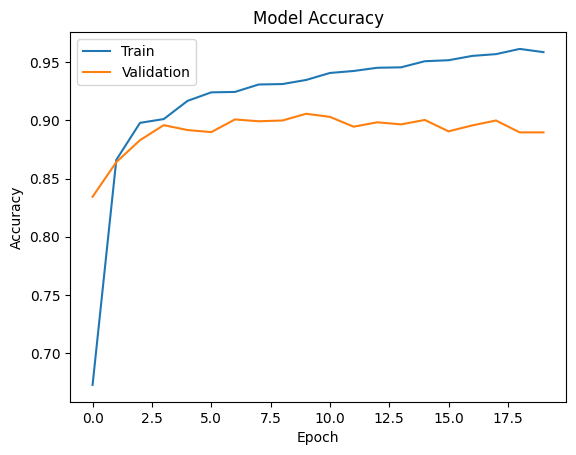

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Simple RNN dengan BOW

In [50]:
vectorizer = CountVectorizer(max_features=1000, min_df=10, max_df=0.5)
X_data_bow = vectorizer.fit_transform(X)
X_data_bow = X_data_bow.toarray()

X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_data_bow, y, test_size=0.25, random_state=42)

input_dim = X_train_bow.shape[1]


In [51]:
X_train_bow = np.expand_dims(X_train_bow, axis=1)
X_test_bow = np.expand_dims(X_test_bow, axis=1)

In [52]:
model_rnn = Sequential(
    [
        SimpleRNN(128, input_shape=(1, input_dim), return_sequences=True),
        SimpleRNN(64, return_sequences=False),
        Dense(32, activation="relu"),
        Dropout(0.4),
        Dense(3, activation="softmax"),
    ]
)

model_rnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model_rnn.summary()

c:\Users\Asus\Documents\Programming\Dicoding\Machine Learning\Pengembangan Machine Learning\submission\submission_analisis_sentimen\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 1, 128)         │       139,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,179 (602.26 KB)

 Trainable params: 154,179 (602.26 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
hist_rnn = model_rnn.fit(X_train_bow, y_train_bow, epochs=20, validation_data=(X_test_bow, y_test_bow))

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6637 - loss: 0.8022 - val_accuracy: 0.8714 - val_loss: 0.3835
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8781 - loss: 0.3642 - val_accuracy: 0.8927 - val_loss: 0.3250
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9069 - loss: 0.3044 - val_accuracy: 0.8991 - val_loss: 0.3241
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9233 - loss: 0.2698 - val_accuracy: 0.9002 - val_loss: 0.3199
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9300 - loss: 0.2466 - val_accuracy: 0.8981 - val_loss: 0.3430
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9318 - loss: 0.2325 - val_accuracy: 0.8967 - val_loss: 0.3635
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9382 - loss: 0.2111 - val_accuracy: 0.9071 - val_loss: 0.3488
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9428 - loss: 0.2065 - val_accuracy: 0.

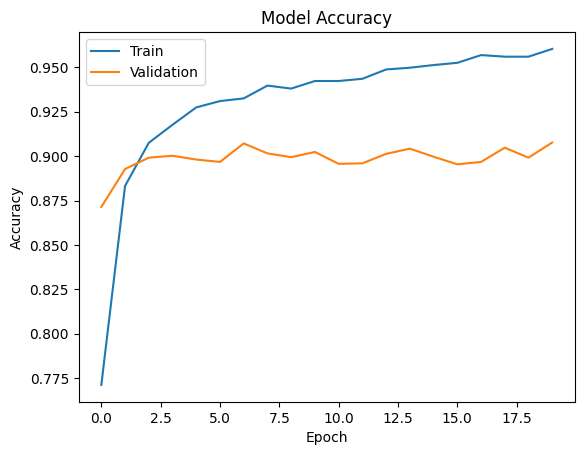

In [54]:
plt.plot(hist_rnn.history["accuracy"])
plt.plot(hist_rnn.history["val_accuracy"])
plt.title("Model Accuracy")

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()


In [55]:
print(f"Akurasi data train: {model_rnn.evaluate(X_train_bow, y_train_bow)[1]}")
print(f"Akurasi data test: {model_rnn.evaluate(X_test_bow, y_test_bow)[1]}")

352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9683 - loss: 0.1128
Akurasi data train: 0.9705542325973511
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9078 - loss: 0.4830
Akurasi data test: 0.9076594710350037


## Testing

In [56]:
def cleaning_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\S+", "", text)
    text = re.sub(r"#\S+", "", text)
    text = re.sub(r"[^A-Za-z]+", " ", text)

    text = text.replace("\n", " ")
    text = text.translate(str.maketrans("", "", string.punctuation))

    text = text.strip()

    return text

def case_folding(text):
    text = text.lower()
    return text

def tokenizing(text):
    text = text.split()
    return text

def stopword_removal(text):
    stop_words = set(stopwords.words("indonesian"))
    text = [word for word in text if word not in stop_words]
    return text

def stemming(text):
    stemmer = StemmerFactory().create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def preprocessing_text(text):
    text = cleaning_text(text)
    text = case_folding(text)
    text = tokenizing(text)
    text = stopword_removal(text)
    text = stemming(text)
    text = " ".join(text)
    return text

In [62]:
review_list = [
    "Game Minecraft ini sangat bagus, keren sekali dan mengasah kreativitas pemain. Keren banget pokoknya!",
    "Saat dimainkan, game ini cukup berat dan membuat handphone cepat panas, namun permainannya tetap seru.",
    "Ada banyak bug dan game sering patah-patah saat dimainkan, sehingga tidak direkomendasikan untuk handphone dengan spesifikasi rendah.",
]

review_list = [preprocessing_text(review) for review in review_list]
review_list


['game minecraft bagus keren asah kreativitas main keren banget pokok',
 'main game berat handphone cepat panas main seru',
 'bug game patah patah main rekomendasi handphone spesifikasi rendah']

In [63]:
dict_class = {
    1: "Positive",
    0: "Negative",
    2: "Neutral"
}

In [64]:
for_classify_svm = tf_idf.transform(review_list).toarray()

for i, review in enumerate(review_list):
    print(f"Review {i+1} : {review}")
    print(f"Sentiment : {dict_class[model_svc.predict(for_classify_svm[i].reshape(1, -1))[0]]}")
    print("")

Review 1 : game minecraft bagus keren asah kreativitas main keren banget pokok
Sentiment : Negative

Review 2 : main game berat handphone cepat panas main seru
Sentiment : Negative

Review 3 : bug game patah patah main rekomendasi handphone spesifikasi rendah
Sentiment : Negative



In [65]:
for_classify_lstm = tokenizer.texts_to_sequences(review_list)
for_classify_lstm = pad_sequences(for_classify_lstm, maxlen=MAX_LENGTH, padding='post')

for i, review in enumerate(review_list):
    print(f"Review {i+1} : {review}")
    print(f"Sentiment : {dict_class[np.argmax(model_lstm.predict(for_classify_lstm[i].reshape(1, -1)))]}")
    print("")

Review 1 : game minecraft bagus keren asah kreativitas main keren banget pokok
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
Sentiment : Negative

Review 2 : main game berat handphone cepat panas main seru
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Sentiment : Negative

Review 3 : bug game patah patah main rekomendasi handphone spesifikasi rendah
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Sentiment : Negative



In [66]:
for_classify_rnn = vectorizer.transform(review_list).toarray()
for_classify_rnn = np.expand_dims(for_classify_rnn, axis=1)

for i, review in enumerate(review_list):
    print(f"Review {i+1} : {review}")
    print(f"Sentiment : {dict_class[np.argmax(model_rnn.predict(for_classify_rnn[i].reshape(1, 1, -1)))]}")
    print("")

Review 1 : game minecraft bagus keren asah kreativitas main keren banget pokok
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
Sentiment : Negative

Review 2 : main game berat handphone cepat panas main seru
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Sentiment : Negative

Review 3 : bug game patah patah main rekomendasi handphone spesifikasi rendah
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sentiment : Negative

